<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1725947133/Frame_10507_1.png" alt="Logo" width="40%">
  </a>
</div>


### 🖹 Descripción: 
Este notebook tiene como objetivo principal aplicar diversas técnicas de clasificación de datos en el conjunto de datos provienente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, y su finalidad es predecir de manera diagnóstica si un paciente tiene diabetes, basándose en un conjunto de mediciones realizadas. Enlace: [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). Con el fin de de explorar herramientas avanzadas de Machine Learning y contribuir al desarrollo del conocimiento a través de la investigación.

### ✍️ Autores: 
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha: 
12 de septiembre de 2024

### 📝 Notas: 
Este notebook es el primero de dos que forman parte del primer proyecto del curso IC6200 - Inteligencia Artificial. Este notebook está titulado "diabetes", mientras que el siguiente se llama "alzheimer".

### Otras notas:
- Asegurarse de que Python esté instalado, junto con las bibliotecas necesarias: pandas, numpy, matplotlib, seaborn, scipy, ydata_profiling, utils.


# 1. Importación de Librerías

In [3]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from IPython.display import display, HTML

from enum import Enum
import random

import Utils as U
import importlib
importlib.reload(U)

<module 'Utils' from 'C:\\Users\\PC MASTER\\Desktop\\ic6200\\proyectos\\IC6200_AI_P1\\src\\Utils.py'>

# 2. Definición de Constantes

In [4]:
FILENAME_D = "./data/diabetes.csv"

SHUFFLE_SEED = 153
COLOR_SEED = 666
PD_MAX_ROWS = 10
PD_MAX_WIDTH = 400

TRAINING_CUT = 0.7 # 70%
SCIKIT_LEARN_RANDOM_STATE = 73

# 3. Configuración ploteo pandas

In [ ]:
pd.set_option('display.max_rows', PD_MAX_ROWS)
pd.set_option('display.width', PD_MAX_WIDTH)

pd.set_option('future.no_silent_downcasting', True)

# 4. Definición de funciones auxiliares

In [5]:
def print_column_types(df):
    print("Column types:")
    for column in df.columns:
        col_name = column.ljust(30)
        col_type = df[column].dtype
        print(f"{col_name} {col_type}")

def print_scores(y_true, y_pred):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Presition
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision:.2f}")
    
    # Recall
    recall = recall_score(y_true, y_pred)
    print(f"Recall: {recall:.2f}")

    # Calcular F1 Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")

    print()

# 5. Definición de estructuras auxiliares

In [6]:
class Custom_Dataframe:
    def __init__(self, name, df, tag_col_name, features_col_names):
        # Constructor de la clase
        self.name = name
        self.df = df
        self.tag_col_name = tag_col_name
        self.features_col_names = features_col_names

    def print_unique_tags(self):
        tags = self.df[self.tag_col_name].unique()
        print(f"Tags: {tags}")

    def replace_col_values(self, replace_dict, col_name):
        df = self.df
        df[col_name] = df[col_name].replace(replace_dict)

    def reduce_dimesionality(self, columns_to_keep):
        # U.printt("self.features_col_names", self.features_col_names)
        # U.printt("columns_to_keep", columns_to_keep)
        self.df = self.df[columns_to_keep]
        columns_to_keep.remove(self.tag_col_name)
        self.features_col_names = columns_to_keep

    def show(self):
        print(self.name)
        print(self.df)

        # Check types
        print_column_types(self.df)

        print()

        # Check unique tags
        self.print_unique_tags()        
        print()
        print()

    def print_tags_balance(self):
        print(self.name)
        total_rows = self.df.shape[0]
        print(f"Total rows = {total_rows}")
        tags = self.df[self.tag_col_name].unique()
        for tag in tags:
            count = self.df[self.df[self.tag_col_name] == tag].shape[0]
            percentage = 100 * count / total_rows
            formatted_percentage = "{:.2f}".format(percentage)
            print(f"Tag: {tag} -> {count} Rows ({formatted_percentage}%)")


class CYBERPUNK_COLORS(Enum):
    Red             = "#e74150"
    Yellow          = "#fee801"
    Green           = "#00ff9f"
    Dark_Blue       = "#005678"
    Night           = "#01012b"
    Cyan            = "#00ffe3"
    Red_Fuchsia     = "#ff1e61"
    Pink_Fuchsia    = "#ff008d"

    @classmethod
    def get_random_color(self, seed):
        random.seed(seed)        
        color_list = list(CYBERPUNK_COLORS)        
        selected_color = random.choice(color_list)
        return selected_color.value

class SEABORN_COLORMAPS(Enum):
    Viridis         = "viridis"
    Plasma          = "plasma"
    Inferno         = "inferno"
    Magma           = "magma"
    Cividis         = "cividis"
    Blues           = "Blues"
    Greens          = "Greens"
    Reds            = "Reds"
    Coolwarm        = "coolwarm"
    Spectral        = "Spectral"
    RdYlBu          = "RdYlBu"
    RdBu            = "RdBu"
    PiYG            = "PiYG"
    PRGn            = "PRGn"
    BrBG            = "BrBG"

    @classmethod
    def get_random_colormap(cls, seed=None):
        if seed is not None:
            random.seed(seed)        
        colormap_list = list(SEABORN_COLORMAPS)        
        selected_colormap = random.choice(colormap_list)
        return selected_colormap.value

# 6. Creación del dataframe principal

In [8]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

def gen_cdf(filename, tag_col_name):
    filepath = Path(filename)

    # Checks read and the file
    if filepath.is_file():
        # Read .csv
        df = pd.read_csv(filepath)
        # Get non-tag columns
        features_col_names = [col for col in df.columns if col != tag_col_name]

        # Dataframe is shuffled to ease bias
        df = df.sample(frac=1, random_state=SHUFFLE_SEED).reset_index(drop=True)

        # Create Dataframe class instance
        cdf = Custom_Dataframe(filename, df, tag_col_name, features_col_names)
        #cdf.show()

        return cdf
    else:
        print(f"Need the file named: {filename}")

cdfd = gen_cdf(FILENAME_D, "Outcome")

# 7. Exploratory Data Analysis (EDA)

## 7.1. Gráficos de barras de características agrupadas por diabetes

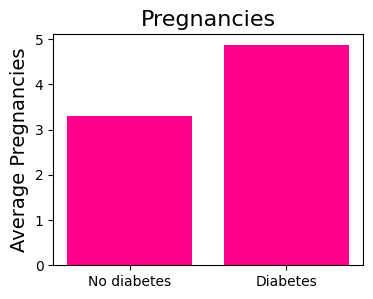

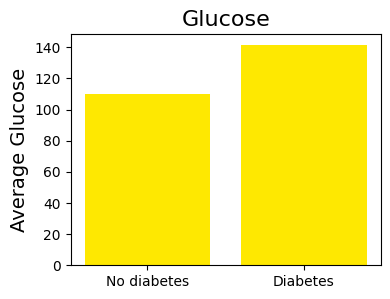

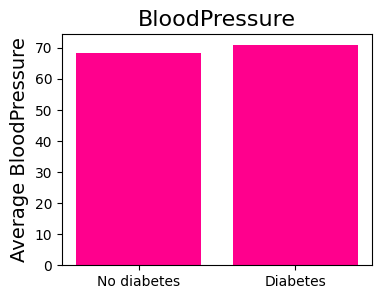

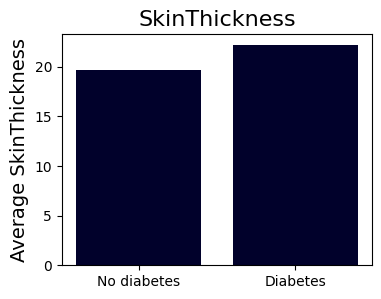

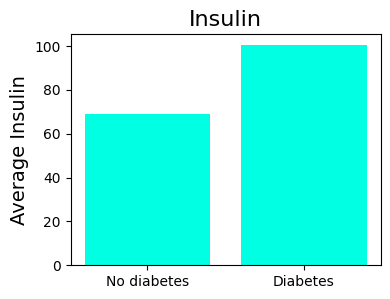

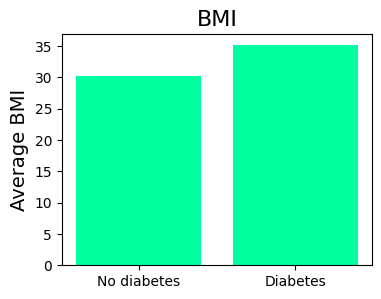

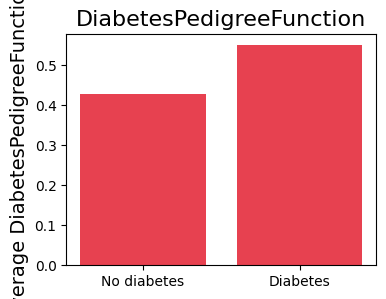

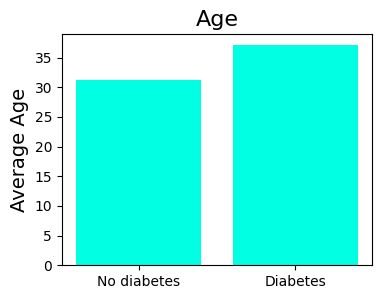

In [9]:
def plot_all_bar(cdf, xticks_labels=[]):
    color_counter = 0
    for feature in cdf.features_col_names:
        ys = []
        tags = cdf.df[cdf.tag_col_name].unique()
        for tag in tags:
            subdf = cdf.df[cdf.df[cdf.tag_col_name] == tag][[feature]]

            mean = subdf.mean().iloc[0]
            std = subdf.std().iloc[0]
            ys.append(mean)

        color = COLOR_SEED + color_counter
        if xticks_labels != []:
            U.plt_bar(categories=tags,
                      magnitudes=ys,
                      fig_width=4,
                      fig_height=3,
                      color=CYBERPUNK_COLORS.get_random_color(color),
                      title=f"{feature}",
                      title_fontsize=16,
                      x_label="",
                      x_fontsize=14,
                      xticks_labels=xticks_labels,
                      y_label=f"Average {feature}",
                      y_fontsize=14)
        color_counter += 1


plot_all_bar(cdfd, ["Diabetes", "No diabetes"])


## 7.2. Informe de correlación de características de la diabetes

The file './reports/Diabetes_Profiling_Report.html' already exists.
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683   

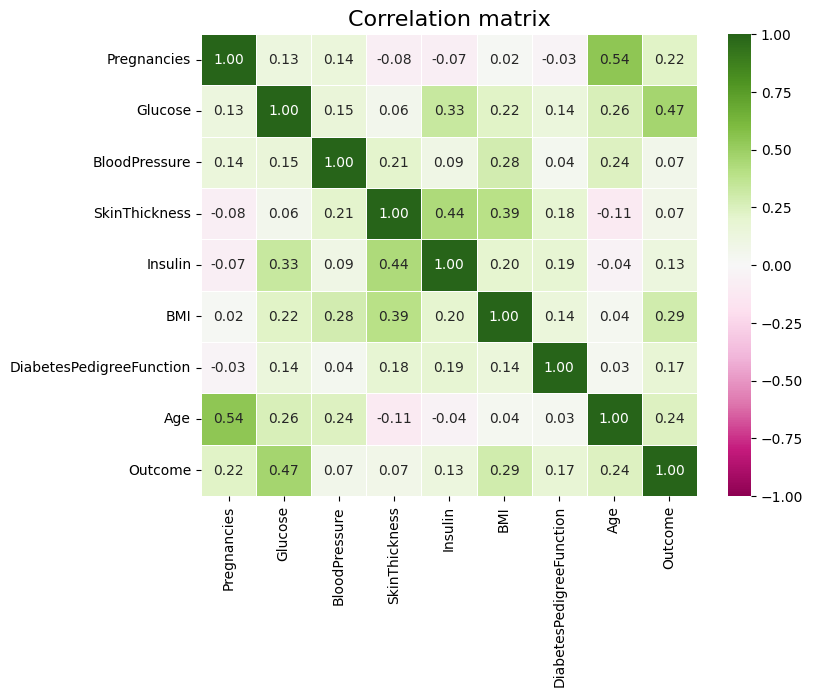

In [10]:
def gen_correlation_report(cdf, report_name, cmap=False):
    if os.path.isfile(report_name):
        print(f"The file '{report_name}' already exists.")
    else:
        profile = ProfileReport(cdf.df, title="Diabetes Profiling Report")
        profile.to_file(output_file=report_name)
        # display(HTML(file_name))

    # Access correlation matrix
    correlation_matrix = cdf.df.corr()
    print(correlation_matrix)

    if(cmap != False):
        # Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

        plt.title('Correlation matrix', fontsize=16)
        plt.show()

gen_correlation_report(cdfd, "./reports/Diabetes_Profiling_Report.html", SEABORN_COLORMAPS.PiYG.value)

Del informe anterior se desprende que la probabilidad de **padecer diabetes está más influenciada por la glucosa y el IMC**, por lo que se utilizarán estas características para entrenar el modelo.

# 8. Reducción de dimensionalidad

In [11]:
columns_to_keep = ['Glucose', 'BMI', 'Outcome']
cdfd.reduce_dimesionality(columns_to_keep)

#cdfd.show()

# 9. División del dataframe

In [12]:
def tvt_df_split(df, test_size=0.3, validation_size=0.5, random_state=SCIKIT_LEARN_RANDOM_STATE):
    train_df, aux_df = train_test_split(df, test_size=test_size, random_state=random_state)
    validation_df, test_df = train_test_split(aux_df, test_size=validation_size, random_state=random_state)
    return train_df, validation_df, test_df



# Diabetes custom dataframes
train_dfd, validation_dfd, test_dfd = tvt_df_split(cdfd.df)

train_cdfd = Custom_Dataframe(name="Diabetes Training Custom Dataframe", df=train_dfd, tag_col_name=cdfd.tag_col_name, features_col_names=cdfd.features_col_names)
validation_cdfd = Custom_Dataframe(name="Diabetes Validation Custom Dataframe", df=validation_dfd, tag_col_name=cdfd.tag_col_name, features_col_names=cdfd.features_col_names)
test_cdfd = Custom_Dataframe(name="Diabetes Testing Custom Dataframe", df=test_dfd, tag_col_name=cdfd.tag_col_name, features_col_names=cdfd.features_col_names)

#train_cdfd.show()
#validation_cdfd.show()
#test_cdfd.show()

# 10. KNN

In [13]:
# Training
X_train_d = train_cdfd.df[train_cdfd.features_col_names]
y_train_d = train_cdfd.df[train_cdfd.tag_col_name]
# Test
X_test_d = test_cdfd.df[test_cdfd.features_col_names]
y_test_d = test_cdfd.df[test_cdfd.tag_col_name]

scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)

for k in range(1, 40, 2):
    # set KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_d, y_train_d)

    # Predict
    y_pred_knn_d = knn.predict(X_test_d)

    # Scores
    print(f"---( k = {k} )---")
    # print_scores(y_true=y_true, y_pred=y_pred)
    # print(f"Diabetes Dataset - KNN Results for k={k}:")
    print_scores(y_test_d, y_pred_knn_d)

---( k = 1 )---
Accuracy: 0.71
Precision: 0.55
Recall: 0.46
F1 Score: 0.50

---( k = 3 )---
Accuracy: 0.78
Precision: 0.69
Recall: 0.59
F1 Score: 0.64

---( k = 5 )---
Accuracy: 0.78
Precision: 0.69
Recall: 0.54
F1 Score: 0.61

---( k = 7 )---
Accuracy: 0.79
Precision: 0.78
Recall: 0.49
F1 Score: 0.60

---( k = 9 )---
Accuracy: 0.80
Precision: 0.79
Recall: 0.51
F1 Score: 0.62

---( k = 11 )---
Accuracy: 0.80
Precision: 0.79
Recall: 0.51
F1 Score: 0.62

---( k = 13 )---
Accuracy: 0.78
Precision: 0.72
Recall: 0.49
F1 Score: 0.58

---( k = 15 )---
Accuracy: 0.78
Precision: 0.73
Recall: 0.51
F1 Score: 0.60

---( k = 17 )---
Accuracy: 0.79
Precision: 0.78
Recall: 0.49
F1 Score: 0.60

---( k = 19 )---
Accuracy: 0.78
Precision: 0.74
Recall: 0.46
F1 Score: 0.57

---( k = 21 )---
Accuracy: 0.77
Precision: 0.71
Recall: 0.46
F1 Score: 0.56

---( k = 23 )---
Accuracy: 0.79
Precision: 0.78
Recall: 0.49
F1 Score: 0.60

---( k = 25 )---
Accuracy: 0.80
Precision: 0.82
Recall: 0.49
F1 Score: 0.61

---(

Mejores valores de  k basados en las métricas:

* F1 Score: El valor más alto de F1 Score es para k=33 (0.68).
* Accuracy: El valor más alto de Accuracy es para k=33 (0.83).
* Precision: El valor más alto de Precision es para k=33 (0.84).

# 11. Regresión Logística

In [14]:
# Initialize and fit the logistic regression classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_d, y_train_d)

# Make predictions
y_pred_log_reg_d = log_reg.predict(X_test_d)

# Evaluate the logistic regression model
print("Diabetes Dataset - Logistic Regression Results:")
print_scores(y_test_d, y_pred_log_reg_d)

Diabetes Dataset - Logistic Regression Results:
Accuracy: 0.81
Precision: 0.83
Recall: 0.51
F1 Score: 0.63



## 11.1 Resultados de regresión

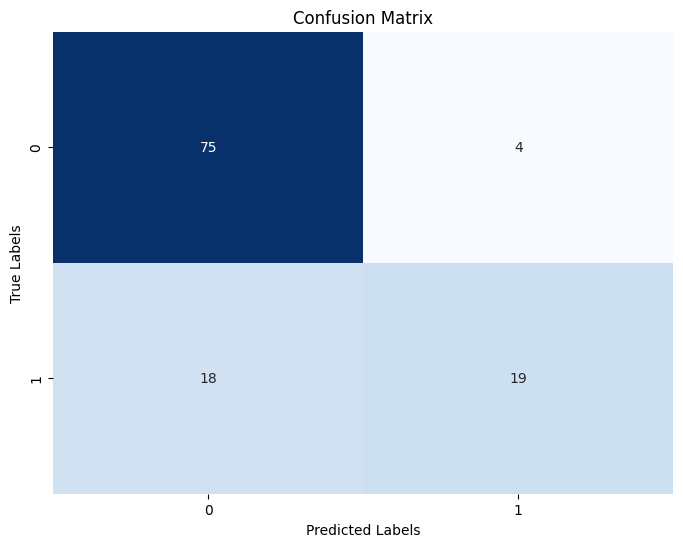

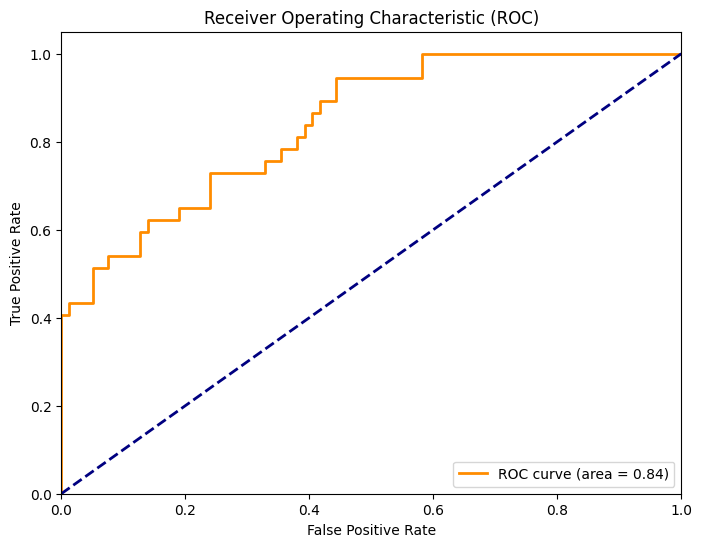

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87        79
           1       0.83      0.51      0.63        37

    accuracy                           0.81       116
   macro avg       0.82      0.73      0.75       116
weighted avg       0.81      0.81      0.80       116

Confusion Matrix:
[[75  4]
 [18 19]]
ROC AUC Score: 0.7314403010605542


In [15]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def print_scores(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))

# Assuming y_test_d are the true labels and y_pred_log_reg_d are the predictions
# Plot confusion matrix
plot_confusion_matrix(y_test_d, y_pred_log_reg_d, labels=[0, 1])

# Plot ROC curve
# Obtain predicted probabilities for the positive class
y_pred_prob_log_reg_d = log_reg.predict_proba(X_test_d)[:, 1]
plot_roc_curve(y_test_d, y_pred_prob_log_reg_d)

# Print scores
print_scores(y_test_d, y_pred_log_reg_d)